In [ ]:
#@title Author : K R Rishikesh

In [1]:
#@title Libraries and Packages
import requests
import json
import numpy as np
from slugify import slugify
import geopy.distance
import random
import operator
from prettytable import PrettyTable
import networkx as nx
import pylab as plt

In [2]:
#@title API Key
bing_maps_key='Ao_XlCU-72D9lr3he5z3njc21LP0lvEFLn8SQzp9HL9e5xLQNX6z3epKdgE3Xt5U'

In [3]:
#@title func : Walking Distance between 2 points
def distance(a,b,c,d):  #finds walking distance between 2 points
  BingMapsKey = bing_maps_key
  lat0,ln0,lat1,ln1 = a,b,c,d
  resp=requests.get(f'https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?origins={lat0},{ln0}&destinations={lat1},{ln1}&travelMode=walking&key={BingMapsKey}')
  resp_dict=resp.json()
  return resp_dict['resourceSets'][0]['resources'][0]['results'][0]['travelDistance']

In [4]:
#@title func : Coordinates of a given location
def coordinates(l): #finds coordinates of a given location
  bingMapsKey = bing_maps_key
  locationQuery=slugify(l,separator='%20')
  locationQuery=f'1600%20{locationQuery}'
  resp=requests.get(f'http://dev.virtualearth.net/REST/v1/Locations/{locationQuery}?format=json&key={bingMapsKey}')
  resp_dict=resp.json()
  retdata=resp_dict['resourceSets'][0]['resources'][0]['point']['coordinates']
  return retdata

In [5]:
#@title func : Finds nearby POIs
def nearbylocs(area,rad): #finds nearby POIs
  try:
    entityTypes=[7996,7933,19,7985,7832,9996,7990,220,275,7992,5999,7998,8231,4493,8410,5813,7947,9992,4444,142,5800,6512,9718,7997]
    nearbynames=[]
    actCost=[]
    hcost=[]
    rc=[]
    for i in range(24):
      rc.append(random.choice(entityTypes))
    bingMapsKey = bing_maps_key
    points=coordinates(area)
    response=requests.get(f"http://spatial.virtualearth.net/REST/v1/data/Microsoft/PointsOfInterest?spatialFilter=nearby({points[0]},{points[1]},{rad})&$filter=EntityTypeId in ({rc[0]},{rc[1]},{rc[2]},{rc[3]},{rc[4]},{rc[5]},{rc[6]},{rc[7]},{rc[8]},{rc[9]},{rc[10]},{rc[11]},{rc[12]},{rc[13]},{rc[14]},{rc[15]},{rc[16]},{rc[17]},{rc[18]},{rc[19]},{rc[20]},{rc[21]},{rc[22]},{rc[23]})&$select=EntityID,DisplayName,Latitude,Longitude,__Distance&$format=json&key={bingMapsKey}")
    resp_dict=response.json()
    nearbylocpoints=np.zeros((25,2))
    for i in range(25):
      nearbylocpoints[i][0]=resp_dict['d']['results'][i]['Latitude']
      nearbylocpoints[i][1]=resp_dict['d']['results'][i]['Longitude']
      nearbynames.append(resp_dict['d']['results'][i]['DisplayName'])
    for i in range(25):
      hcost.append(heuristicCalc(points[0],points[1],nearbylocpoints[i][0],nearbylocpoints[i][1]))
      a=distance(points[0],points[1],nearbylocpoints[i][0],nearbylocpoints[i][1])
      if a==-1:
        a=abs(a)
      elif a==0 and hcost[i]==0:
        a=0.05
      elif a==0 and hcost[i]!=0:
        a=hcost[i]+0.1
      actCost.append(a)
    return nearbylocpoints,nearbynames,actCost,hcost
  except:
    print(f'No nearby POI of specified type can be found in radius of {rad} kms')

In [6]:
#@title func : Straight line distance between 2 points
def heuristicCalc(lat,lon,lat1,lon1): #finds heuristic distance between 2 points (straight line distance)
  goalState=(lat,lon)
  currentState=(lat1,lon1)
  return geopy.distance.geodesic(currentState,goalState).km

In [7]:
#@title func : Prints nearby POI names
def nearByLocations(loc,rad):  #prints nearby POI names
  nearTable = PrettyTable(["Names of nearby POI"])
  nearpoints,nearbyNames,aCost,hCost=nearbylocs(loc,rad)
  for i in range(25):
    nearTable.add_row([nearbyNames[i]])
  print(nearTable)
  return loc,nearpoints,nearbyNames,aCost,hCost

In [16]:
#@title func : Prints the current location, distances to other nearby locations from current location, and total distance for the path
def inputData(l,nearpoints,nearbyNames,aCost,hCost): #prints the current location, distances to other nearby locations from current location, and total distance for the path
  nodeList=[]
  myTable = PrettyTable(["Place Name", "Actual Distance (km)", "Heuristic Distance (km)", "Total Distance (km)"])
  count=0
  totCost=0
  totActCost=0
  print('\n')
  while(count<25):
    if count==0:
      print(f'0. {l} -> Start here')
    else:
      print(f'{count}. {l}')
    if l not in nodeList:
      nodeList.append(l)
    loc,lati,longi=AstarAlgo(nearbyNames,aCost,hCost,nearpoints,count)
    print('\n')
    for i in range(len(nearpoints)):
      myTable.add_row([nearbyNames[i],aCost[i],hCost[i],aCost[i]+hCost[i]])
    print(myTable)
    l=loc
    index=nearbyNames.index(loc)
    nearbyNames.remove(loc)
    totActCost+=aCost[index]
    totCost+=(aCost[index]+hCost[index])
    del aCost[index]
    del hCost[index]
    nearpoints=np.delete(nearpoints,(index),axis=0)
    aCost,hCost=distanceCalc(lati,longi,nearpoints,count)
    count+=1
    myTable.clear_rows()
    print('\n')
  nodeList.append(l)
  print(f'25. {l} -> Ends here')
  print(f'\nTotal Actual Distance for Path = {totActCost} km\nTotal Distance for Path (Actual+Heuristic) = {totCost} km')
  return nodeList

In [9]:
#@title func : Actual and Heuristic distance calculations from current location to other locations and updates distances
def distanceCalc(lat,lon,points,count): #does actual and heuristic distance calculations from current location to other locations and updates distances
  c=[]
  h=[]
  no=25-(count+1)
  for i in range(no):
    h.append(heuristicCalc(lat,lon,points[i][0],points[i][1]))
    a=distance(lat,lon,points[i][0],points[i][1])
    if a==-1:
      a=abs(a)
    elif a==0 and h[i]==0:
        a=0.05
    elif a==0 and h[i]!=0:
        a=h[i]+0.1
    c.append(a)
  return c,h

In [10]:
#@title func : Performs A* by sorting all nearby locations based on their total cost, and returning the name and coordinates of the location with least total cost
def AstarAlgo(nearnames,actCost,hCost,points,count):  #performs A* by sorting all nearby locations based on their total cost, and returning the name and coordinates of the location with least total cost
  f=[]
  for i in range(len(nearnames)):
   f.append(actCost[i]+hCost[i])
  if(count==0):
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]],f'{nearnames[15]}':[f[15],points[15][0],points[15][1]],
           f'{nearnames[16]}':[f[16],points[16][0],points[16][1]],f'{nearnames[17]}':[f[17],points[17][0],points[17][1]],
           f'{nearnames[18]}':[f[18],points[18][0],points[18][1]],f'{nearnames[19]}':[f[19],points[19][0],points[19][1]],
           f'{nearnames[20]}':[f[20],points[20][0],points[20][1]],f'{nearnames[21]}':[f[21],points[21][0],points[21][1]],
           f'{nearnames[22]}':[f[22],points[22][0],points[22][1]],f'{nearnames[23]}':[f[23],points[23][0],points[23][1]],
           f'{nearnames[24]}':[f[24],points[24][0],points[24][1]]
           }
  elif count==1:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]],f'{nearnames[15]}':[f[15],points[15][0],points[15][1]],
           f'{nearnames[16]}':[f[16],points[16][0],points[16][1]],f'{nearnames[17]}':[f[17],points[17][0],points[17][1]],
           f'{nearnames[18]}':[f[18],points[18][0],points[18][1]],f'{nearnames[19]}':[f[19],points[19][0],points[19][1]],
           f'{nearnames[20]}':[f[20],points[20][0],points[20][1]],f'{nearnames[21]}':[f[21],points[21][0],points[21][1]],
           f'{nearnames[22]}':[f[22],points[22][0],points[22][1]],f'{nearnames[23]}':[f[23],points[23][0],points[23][1]]
           }
  elif count==2:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]],f'{nearnames[15]}':[f[15],points[15][0],points[15][1]],
           f'{nearnames[16]}':[f[16],points[16][0],points[16][1]],f'{nearnames[17]}':[f[17],points[17][0],points[17][1]],
           f'{nearnames[18]}':[f[18],points[18][0],points[18][1]],f'{nearnames[19]}':[f[19],points[19][0],points[19][1]],
           f'{nearnames[20]}':[f[20],points[20][0],points[20][1]],f'{nearnames[21]}':[f[21],points[21][0],points[21][1]],
           f'{nearnames[22]}':[f[22],points[22][0],points[22][1]]
           }
  elif count==3:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]],f'{nearnames[15]}':[f[15],points[15][0],points[15][1]],
           f'{nearnames[16]}':[f[16],points[16][0],points[16][1]],f'{nearnames[17]}':[f[17],points[17][0],points[17][1]],
           f'{nearnames[18]}':[f[18],points[18][0],points[18][1]],f'{nearnames[19]}':[f[19],points[19][0],points[19][1]],
           f'{nearnames[20]}':[f[20],points[20][0],points[20][1]],f'{nearnames[21]}':[f[21],points[21][0],points[21][1]]
           }
  elif count==4:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]],f'{nearnames[15]}':[f[15],points[15][0],points[15][1]],
           f'{nearnames[16]}':[f[16],points[16][0],points[16][1]],f'{nearnames[17]}':[f[17],points[17][0],points[17][1]],
           f'{nearnames[18]}':[f[18],points[18][0],points[18][1]],f'{nearnames[19]}':[f[19],points[19][0],points[19][1]],
           f'{nearnames[20]}':[f[20],points[20][0],points[20][1]]
           }
  elif count==5:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]],f'{nearnames[15]}':[f[15],points[15][0],points[15][1]],
           f'{nearnames[16]}':[f[16],points[16][0],points[16][1]],f'{nearnames[17]}':[f[17],points[17][0],points[17][1]],
           f'{nearnames[18]}':[f[18],points[18][0],points[18][1]],f'{nearnames[19]}':[f[19],points[19][0],points[19][1]]
           }
  elif count==6:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]],f'{nearnames[15]}':[f[15],points[15][0],points[15][1]],
           f'{nearnames[16]}':[f[16],points[16][0],points[16][1]],f'{nearnames[17]}':[f[17],points[17][0],points[17][1]],
           f'{nearnames[18]}':[f[18],points[18][0],points[18][1]]
           }
  elif count==7:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]],f'{nearnames[15]}':[f[15],points[15][0],points[15][1]],
           f'{nearnames[16]}':[f[16],points[16][0],points[16][1]],f'{nearnames[17]}':[f[17],points[17][0],points[17][1]]
           }
  elif count==8:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]],f'{nearnames[15]}':[f[15],points[15][0],points[15][1]],
           f'{nearnames[16]}':[f[16],points[16][0],points[16][1]]
           }
  elif count==9:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]],f'{nearnames[15]}':[f[15],points[15][0],points[15][1]]
           }
  elif count==10:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]],
           f'{nearnames[14]}':[f[14],points[14][0],points[14][1]]
           }
  elif count==11:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]],f'{nearnames[13]}':[f[13],points[13][0],points[13][1]]
    }
  elif count==12:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]],
           f'{nearnames[12]}':[f[12],points[12][0],points[12][1]]
           }
  elif count==13:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]],f'{nearnames[11]}':[f[11],points[11][0],points[11][1]]
           }
  elif count==14:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]],
           f'{nearnames[10]}':[f[10],points[10][0],points[10][1]]
           }
  elif count==15:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]],f'{nearnames[9]}':[f[9],points[9][0],points[9][1]]
           }
  elif count==16:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]],
           f'{nearnames[8]}':[f[8],points[8][0],points[8][1]]
           }
  elif count==17:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]],f'{nearnames[7]}':[f[7],points[7][0],points[7][1]]
           }
  elif count==18:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]],
           f'{nearnames[6]}':[f[6],points[6][0],points[6][1]]
           }
  elif count==19:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]],f'{nearnames[5]}':[f[5],points[5][0],points[5][1]]
           }
  elif count==20:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]],
           f'{nearnames[4]}':[f[4],points[4][0],points[4][1]]
           }
  elif count==21:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]],f'{nearnames[3]}':[f[3],points[3][0],points[3][1]]
           }
  elif count==22:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]],
           f'{nearnames[2]}':[f[2],points[2][0],points[2][1]]
           }
  elif count==23:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]],f'{nearnames[1]}':[f[1],points[1][0],points[1][1]]
           }
  elif count==24:
    my_dict={f'{nearnames[0]}':[f[0],points[0][0],points[0][1]]
           }
  sortmy_dict = sorted(my_dict.items(), key=operator.itemgetter(1)) 
  res = next(iter(sortmy_dict))
  if len(sortmy_dict)!=0:
    return res[0],res[1][1],res[1][2]
  else:
    return

In [11]:
#@title Welcome to Itinenary Planner [ Enter a detailed area name to get accurate results ]
Area='Times Square' #@param {type:"string"}
Search_Radius='2' #@param {type:"string"}

l,nearp,nearn,Acost,Hcost=nearByLocations(Area,Search_Radius) #call this function first, to get list of nearby POIS

+-----------------------------------------+
|           Names of nearby POI           |
+-----------------------------------------+
|           Saddles Bar & Grill           |
|          Chelsea's White Dragon         |
| Rocky Mountain Day Spa Boutique & Salon |
|              The Paramount              |
|             Slopeside Grill             |
|       Snowflower at Steamboat GNDL      |
|         The Steamboat Base Club         |
|               The Tugboat               |
|                   Yama                  |
|                Cafe Diva                |
|                Los Locos                |
|                 Hazie's                 |
|           Gondola Pub & Grill           |
|         Stoker Bar & Restaurant         |
|              Timber & Torch             |
|              Gnarly Charly              |
|        Chocolate Soup Pastry Cafe       |
|                The Cabin                |
|              The Grand Spa              |
|                Talay Thai     

In [12]:
#@title Get Optimal Path with Total Path Distance
n=inputData(l,nearp,nearn,Acost,Hcost)



0. Times Square -> Start here


+-----------------------------------------+----------------------+-------------------------+---------------------+
|                Place Name               | Actual Distance (km) | Heuristic Distance (km) | Total Distance (km) |
+-----------------------------------------+----------------------+-------------------------+---------------------+
|           Saddles Bar & Grill           |        0.046         |   0.05277734695711547   | 0.09877734695711547 |
|          Chelsea's White Dragon         |        0.169         |    0.1300479986317294   |  0.2990479986317294 |
| Rocky Mountain Day Spa Boutique & Salon |        0.208         |   0.15871072130879668   | 0.36671072130879667 |
|              The Paramount              |        0.235         |   0.16564032114800625   | 0.40064032114800624 |
|             Slopeside Grill             |        0.235         |   0.16994179403921023   |  0.4049417940392102 |
|       Snowflower at Steamboat GNDL      |   

In [15]:
#@title Print Visiting Order
table=PrettyTable(['Visiting Order','Place Name'])
print('Order of visiting the nearby places')
for i in range(len(n)):
  table.add_row([i,n[i]])
print(table)

Order of visiting the nearby places
+----------------+-----------------------------------------+
| Visiting Order |                Place Name               |
+----------------+-----------------------------------------+
|       0        |               Times Square              |
|       1        |           Saddles Bar & Grill           |
|       2        |          Chelsea's White Dragon         |
|       3        |           Gondola Pub & Grill           |
|       4        |                 Hazie's                 |
|       5        |         Stoker Bar & Restaurant         |
|       6        |              Gnarly Charly              |
|       7        |              Timber & Torch             |
|       8        |               Truffle Pigs              |
|       9        |                 Tune Up                 |
|       10       | Rocky Mountain Day Spa Boutique & Salon |
|       11       |              The Paramount              |
|       12       |             Slopeside Grill   

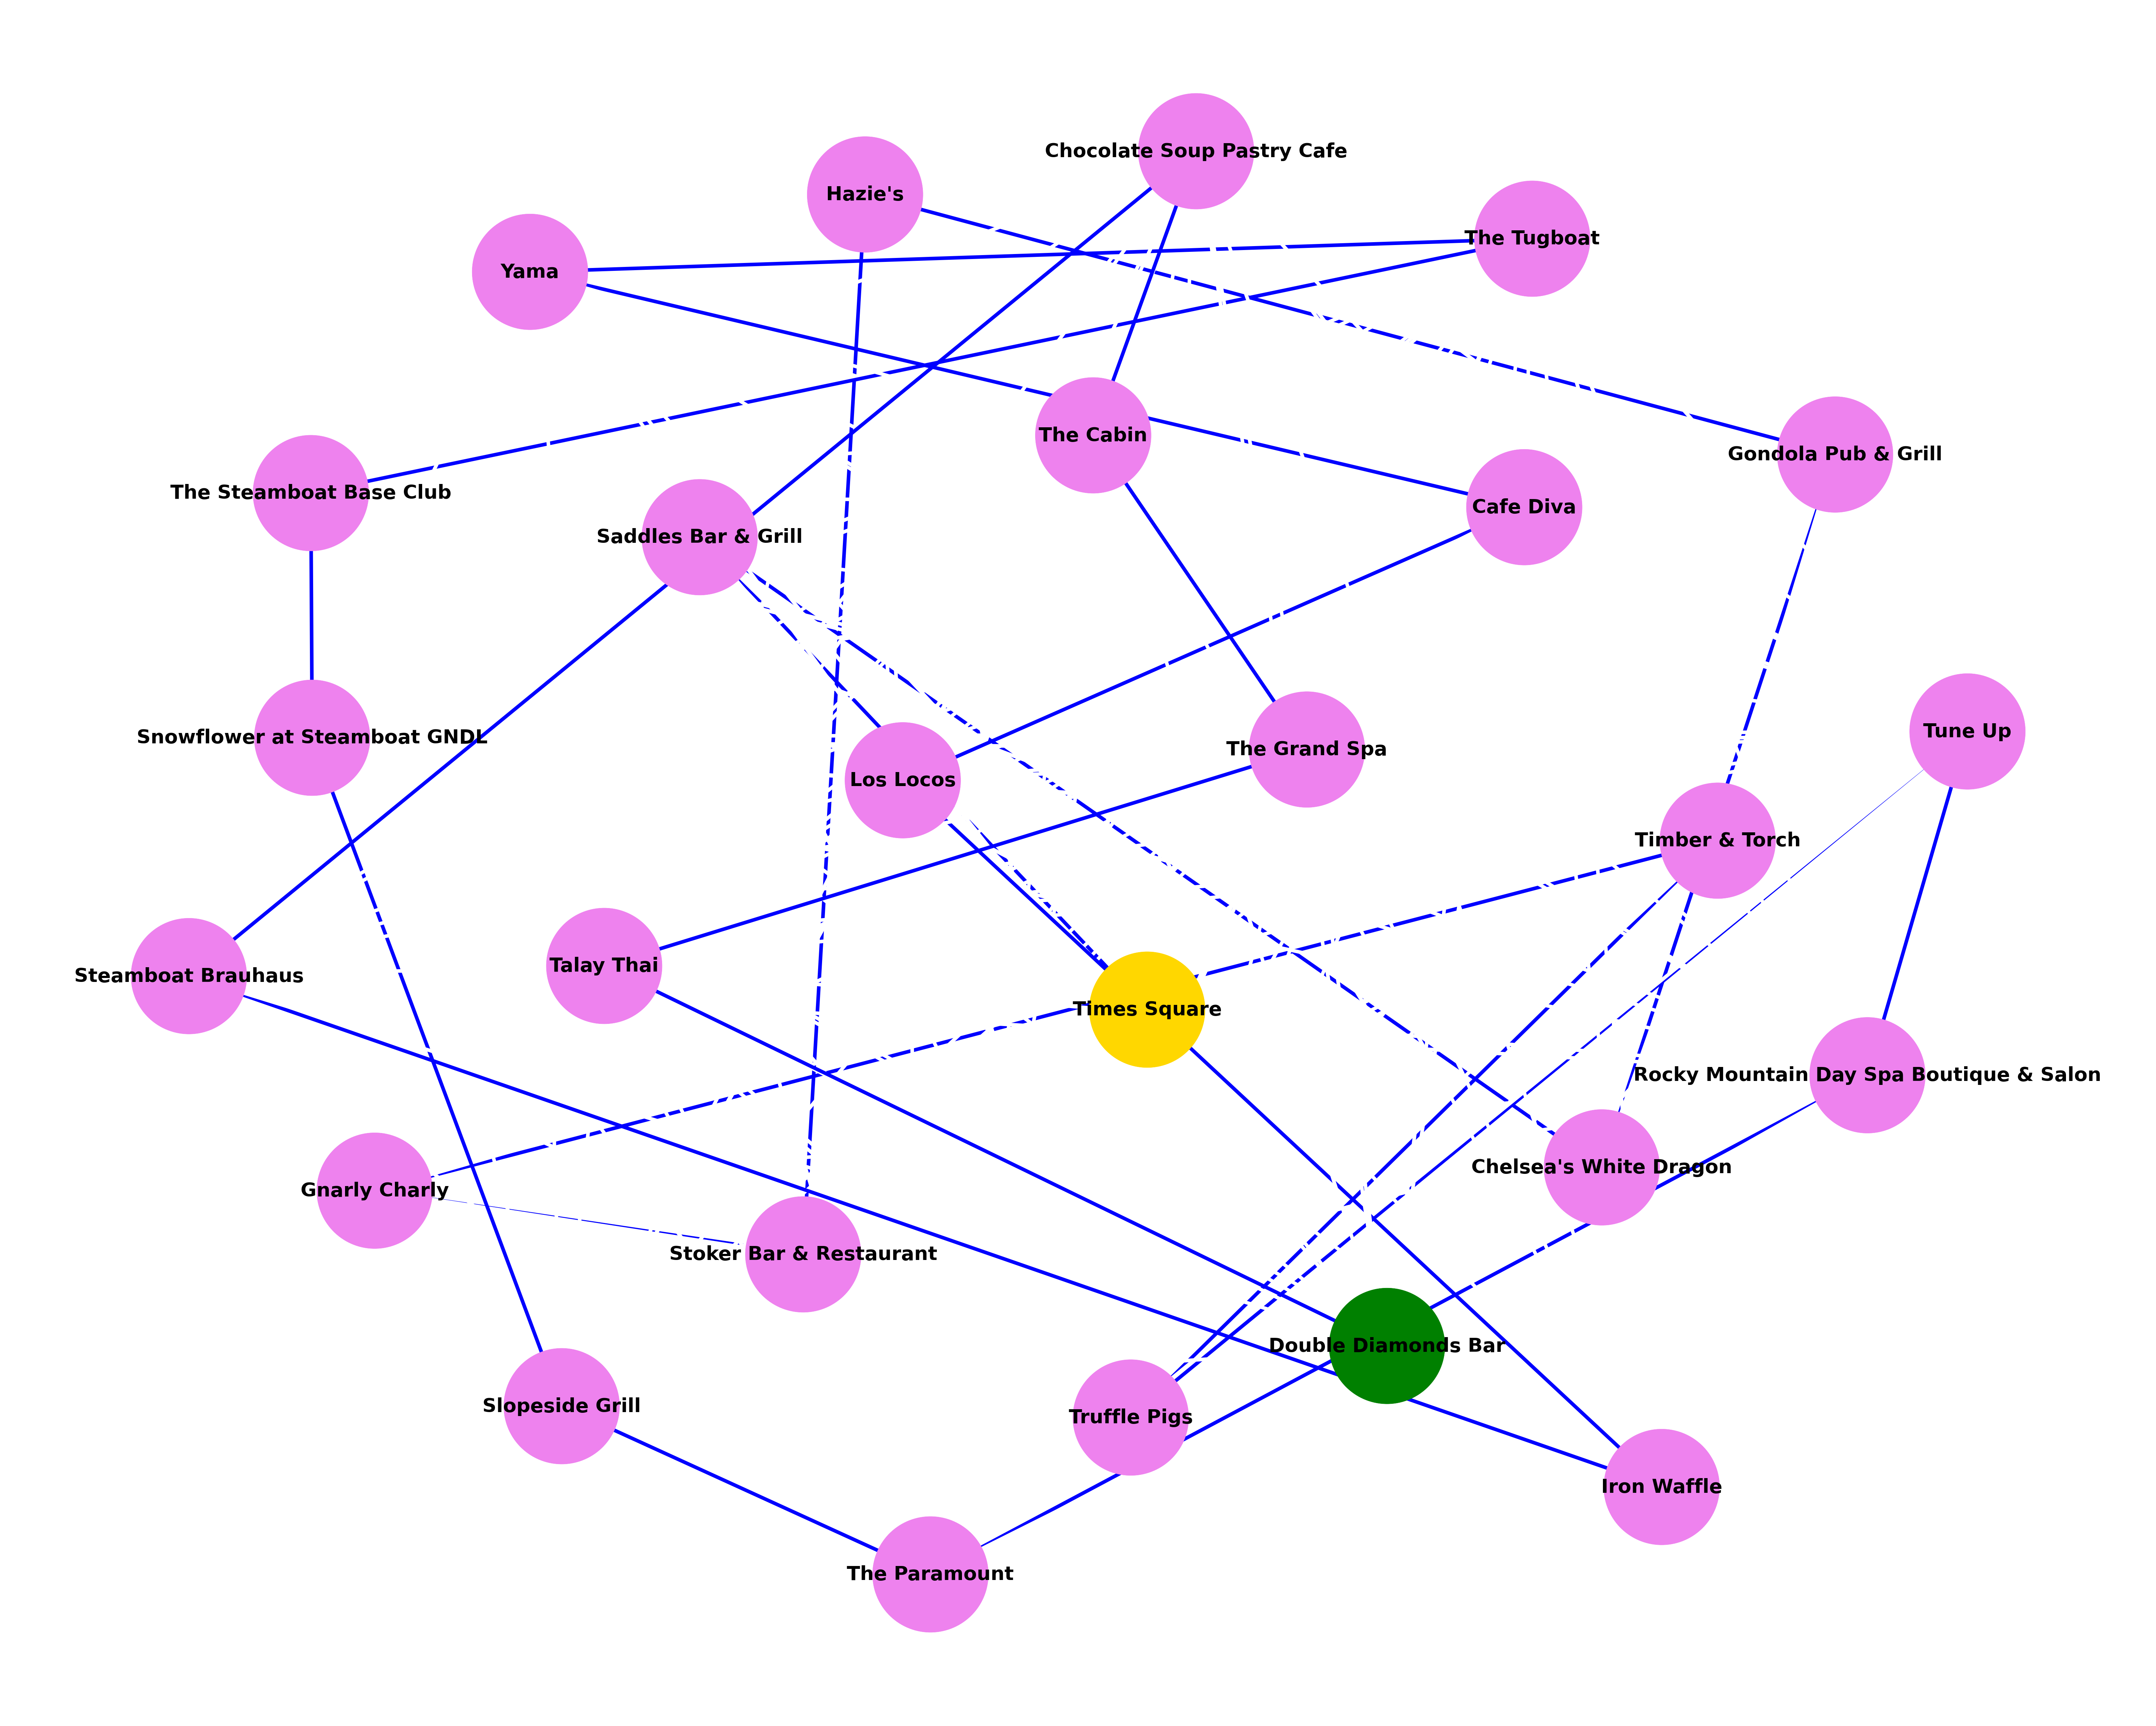

In [19]:
#@title Graph
m = ['gold']
for i in range(len(n) - 2):
  m.append('violet')
m.append('green')
G=nx.Graph()
for i in range (0,len(n)):
   for j in range (i+1,len(n)):
      if (j == i+1):
         G.add_edge(n[i], n[j], color = 'b', weight = 12)
      else:
         G.add_edge(n[i], n[j], color = 'w', weight = 12)
edges = G. edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
fig = plt.figure(1, figsize=(100, 80), dpi=60)
pos = nx.spring_layout(G)
nx. draw(G, pos, edgelist = edges, node_size = 150000, node_color=m, edge_color=colors, width=weights, font_size=65, font_weight='bold',  with_labels=True)